<a href="https://colab.research.google.com/github/D3TaLES/In-The-Mix/blob/main/data_science/InTheMix2_DataScineceDay2_MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap

1. Supervised learning is ...


2. To better find materials for redox-flow batteries, it is important to be able to quickly estimate vertical electron affinity. 


# Principles of Supervised ML

# Principles in Action: Training supervised ML models
>Goal: Train ML model to predict vertical electron affinity

# Terminology Explanation


Data visualization and preprocessing:

Data visualization is like drawing a picture to show the data, which helps us see patterns or trends. Data preprocessing is like cleaning up and organizing the data so that it's easy for the computer to understand and work with. This helps the computer learn better from the data and make accurate predictions.


Train Test split:

When we teach a computer using data, we need to check how well it's learning. So, we split the data into two parts – one for teaching (training set) and one for checking (testing set). This helps us make sure the computer can understand new, unseen information and not just memorize what it was taught. The most commom way to do the train test split is randomly pick 80% of the data for training and the remainimg 20% for testing.

Choosing the right model:

Just like different tools are used for different tasks, there are different computer models for different problems. We need to choose the right model for the job, based on the type of problem, the data we have, and the results we want. Trying different models and comparing their performance can help us find the best one for our task.

Steps to choose  a good model:
1. Understand the problem: First, figure out what kind of problem you're trying to solve. Is it about classifying things (like cats and dogs), predicting numbers (like house prices), or finding relationships between data points (like how exercise affects health)?
2. Explore the data: Take a look at your data to see what's in it. Are there images, text, or numbers? Are there missing values or unusual patterns? This can help you choose a model that works well with that kind of data.
3. Start simple: Try starting with a simple model, like a decision tree. If it doesn't perform well, you can move on to more complex models.
4. Experiment and compare: Test different models on your data and compare their performance. Keep track of their accuracy, speed, and any other factors that are important for your task.


Loss Function:

A loss function is like a scorecard that tells us how good or bad the computer's predictions are compared to the real answers. Our goal is to help the computer get better at predicting by minimizing the difference between its predictions and the actual values. The loss function guides the computer to make adjustments and improve its performance.


Loss functions are like scoring systems in a game. They tell us how well our computer model is doing by measuring the difference between its predictions and the actual answers (the real data). Here are a few common loss functions:
Mean Squared Error (MSE): This loss function calculates the average of the squared differences between the model's predictions and the actual answers. It's often used in problems where we want to predict numbers, like house prices or temperatures.
Cross-Entropy: This loss function is used when we want to classify things, like deciding if a picture is of a cat or a dog. It measures how well our model can predict the correct category, rewarding the model if it's confident about the right answer and penalizing it if it's confident about the wrong one.

To choose the right loss function, please remenber to match the problem type. Pick a loss function that works well with the kind of problem you're trying to solve. For example, use Mean Squared Error for predicting numbers and Cross-Entropy for classifying things.





Hyperparameter tuning:

When we set up a computer model, there are some settings we need to choose before it starts learning. These settings are called hyperparameters. Hyperparameter tuning is like fine-tuning the computer model to work better with our data. By trying different settings and comparing how well the computer performs, we can find the best combination of settings for our task.

In [ ]:
# REST API class
#@title Install and import required packages
!pip install rdkit

import json
import warnings
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolDescriptors import *

from keras.models import Sequential
from keras.layers import Dense

USERNAME = 'd3tales.edu@gmail.com'
PASSWORD = 'D3education'

class RESTAPI(object):
    def __init__(self, method=None, url="https://d3tales.as.uky.edu", endpoint=None,
                 login_endpoint='login', username=USERNAME, password=PASSWORD,
                 upload_file=None, params=None, expected_endpoint=None, return_json=False):
        """
        Upload a file to through d3tales.as.uky.edu file upload feature.

        :param method: str, html method (such as post or get)
        :param url: str, base url
        :param endpoint: str, post or get endpoint url (not containing base url)
        :param login_endpoint: str, login url (not containing base url)
        :param username: str, user username
        :param password: str, user password
        :param upload_file: str, path to file to be uploaded
        :param params: dict, form parameters for post
        :param return_json: bool, get or post method returns json if true
        """
        self.method = method
        self.endpoint = "{}/{}/".format(url, endpoint).replace("//", "/").replace(':/', '://')
        self.login_endpoint = "{}/{}/".format(url, login_endpoint).replace("//", "/").replace(':/', '://')
        if expected_endpoint:
            self.expected_endpoint = "{}/{}/".format(url, expected_endpoint).replace("//", "/").replace(':/', '://')
        self.user_data = dict(username=username, password=password) if username and password else None
        
        self.client = self.get_client()
        params.update(dict(csrfmiddlewaretoken=self.csrftoken, next='/')) if params else {}
        self.params = params or {}
        self.upload_file = upload_file
        self.return_json = return_json

        if self.method in ["get", "GET", "Get"]:
            self.response = self.get_process()

        elif self.method in ["POST", "post", "Post"]:
            self.response = self.post_process()

        if expected_endpoint:
            if self.response.request.url != self.expected_endpoint:
                warnings.warn("The {} response url for {} to {} did not match the expected response url".format(
                    self.upload_file, self.endpoint, self.method))
        
    @property
    def cookies(self):
        return self.client.get(self.endpoint).cookies  # sets cookie

    @property
    def csrftoken(self):
        # Retrieve the CSRF token for data post
        return self.cookies['csrftoken'] if 'csrftoken' in self.cookies else self.cookies['csrf']

    def get_client(self):
        with requests.Session() as client:
            if self.login_endpoint and self.user_data:
                # Login
                client.get(self.login_endpoint)  # sets cookie
                csrftoken = client.cookies['csrftoken'] if 'csrftoken' in client.cookies else client.cookies['csrf']
                self.user_data.update(dict(csrfmiddlewaretoken=csrftoken, next='/'))
                # Submit login form
                req = client.post(self.login_endpoint, data=self.user_data, headers=dict(Referer=self.login_endpoint))
            return client

    def post_process(self):
        # Submit data form
        file_data = dict(file=open(self.upload_file, 'rb')) if self.upload_file else None
        req = self.client.post(self.endpoint, data=self.params, files=file_data,
                               headers=dict(Referer=self.endpoint), cookies=self.cookies)
        return_data = req.json() if self.return_json else req
        return return_data

    def get_process(self):
        if self.params:
            req = self.client.get(self.endpoint, data=self.params, headers=dict(Referer=self.endpoint), cookies=self.cookies)
        else:
            req = self.client.get(self.endpoint, headers=dict(Referer=self.endpoint))

        return_data = req.json() if self.return_json else req
        return return_data


def get_prop(prop="oxidation_potential", limit=500): 
  query = "mol_characterization." + prop + "==true/mol_info.smiles=1&mol_characterization." + prop + "=1/limit=" + str(limit)
  print("Collecting data through REST API...")
  response = RESTAPI(method='get', endpoint="restapi/molecules/"+query, 
                      url="https://d3tales.as.uky.edu", login_endpoint='login',
                      return_json=True).response
  comp_data = pd.DataFrame(response)
  get_value = lambda c: c.get(prop)[0].get("value")
  comp_data['smiles'] = comp_data.mol_info.apply(lambda c: c.get("smiles"))
  comp_data[prop] = comp_data.mol_characterization.apply(get_value)
  comp_data

  comp_data.set_index(comp_data._id, inplace=True)
  comp_data.drop(['_id', 'mol_info', 'mol_characterization' ], axis=1, inplace=True)
  
  return comp_data
# get_prop(prop="vertical_electron_affinity", limit=5)

## Data preparation

Data preparation is an important part of machine learning...

In [ ]:
#@title Loading and preprocessing data

raw_df = get_prop(prop = 'vertical_electron_affinity', limit=10000).reset_index(drop=True)

mol = []
Kappa1 = []
Kappa2 = []
LabuteASA = []
calc1v = []
calc2v = []
MolMR = []
NumHD = []
for i in range(len(raw_df)):
        mol.append(Chem.MolFromSmiles(raw_df['smiles'][i]))
        Kappa1.append(CalcKappa1(mol[i]))
        LabuteASA.append(CalcLabuteASA(mol[i]))
        calc1v.append(CalcChi1v(mol[i]))

d = pd.DataFrame({'Kappa1':Kappa1, 'LabuteASA':LabuteASA, 'CalcChi1v':calc1v})
d = d.join(raw_df['vertical_electron_affinity'])
print(d)

In [ ]:
#@title Select sample size

Response = 'vertical_electron_affinity'
Feature1 = 'Kappa1'
Feature2 = 'CalcChi1v'
Feature3 = 'LabuteASA'

Sample_Size =  500 #@param {type:"integer"}
data_itm = pd.DataFrame({'Response':d[Response], 'Feature1':d[Feature1], 'Feature2':d[Feature2], 'Feature3':d[Feature3]}).sample(Sample_Size)
#data_itm = pd.DataFrame({'Response':d[Response], 'Feature1':d[Feature1], 'Feature2':d[Feature2], 'Feature3':d[Feature3]})

In [ ]:
#@title Loading data
pr = ['vertical_electron_affinity', 'adiabatic_ionization_energy', 'vertical_ionization_energy']
#data = pd.DataFrame()
data = []
for i in range(len(pr)):
  raw = get_prop(prop = pr[i], limit=10000) 
  print(raw)
  #data.merge(data,data, on='smiles')
data_n = data.to_numpy()
data_fn = data_n[~np.isnan(data_n).any(axis=1),:]  

In [ ]:
#@title Splitting data for training and testing
y = data_fn[:,0]
X = data_fn[:,[1,2]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Linear Regression



## Linear Regression

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

How has the linear regression performed? Let's use our test data to find out

In [ ]:
#@title
y_pred_reg = reg.predict(X_test)
r2_score(y_test, y_pred_reg)

## Random Forest (RF) Supervised Learning

In [ ]:
#@title
rannfor = RandomForestRegressor()
rannfor.fit(X_train, y_train)

How has the random forest performed? Let's find out!

In [ ]:
#@title
y_pred_rf = rannfor.predict(X_test)
r2_score(y_test, y_pred_rf)

The last two models have not performed well! why is this?

Traditional machine learning models are often bound by many statistical assumptions which create issues when handling complex data that often violate those assumtions.

For example the linear regression aims to find a linear relationship between the smiles and electron affinity. But the actual relationship is actually not linear which is why we get a huge margin of error in predictions hence poor results!

Deep Learning models have been found to be effective in handling these challenging situations! Let's see if deep models can save our mission!!

## Neural Networks (NN) for Supervised Learning

In [ ]:
#@title Snippet of the dataset
data_itm.head()

In [ ]:
#@title Creating neural net
Number_of_input_units =  7#@param {type:"integer"}
Number_of_output_units = 1#@param {type:"integer"}
Number_of_hidden_layers = 3#@param {type:"integer"}
Number_of_hidden_units = []
for i in range(0, Number_of_hidden_layers):
            print("The number of neurons for hidden layer " + str(i+1) + ":")
            ele = int(input())
            Number_of_hidden_units.append(ele) # adding the element
#Number_of_hidden_units - inp_list.split(",")
Number_of_ephocs =  50#@param {type:"integer"}
Batch_size =  10#@param {type:"integer"}
Test_Data_Size =  30#@param {type:"number"}


model_parameters = {}
model_parameters['hidden_units'] = Number_of_hidden_units
model_parameters['input_size'] = Number_of_input_units
model_parameters['output_size'] = Number_of_output_units

training_parameters = {}
training_parameters['epoch'] = Number_of_ephocs
training_parameters['batch_size'] = Batch_size
training_parameters['loss'] = 'mean_squared_error'
training_parameters['optimizer'] = 'adam'

Target = ['Response']
Feature = ['Feature1', 'Feature2','Feature3']

X = data_itm[Feature].values
y = data_itm[Target].values

FeatureScaler=StandardScaler()
TargetVarScaler=StandardScaler()
  
# Storing the fit object for later reference
FeatureScalerFit=FeatureScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X=FeatureScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

  # Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=Test_Data_Size/1005, random_state=42)

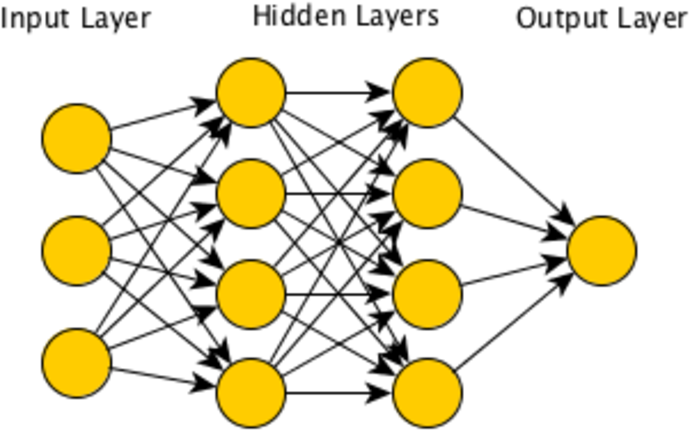

In [ ]:
#@title Function to train the network

def train_and_test_model(dataset, Target, Feature, model_params, train_params, test, verbose=True):
  # Target = ['Response']
  # Predictor = ['Prop1', 'Prop2']

  assert(model_params['output_size'] == len(Target))
  assert(model_params['input_size'] == len(Feature))

  X = dataset[Feature].values
  y = dataset[Target].values

  FeatureScaler=StandardScaler()
  TargetVarScaler=StandardScaler()
  
  # Storing the fit object for later reference
  FeatureScalerFit=FeatureScaler.fit(X)
  TargetVarScalerFit=TargetVarScaler.fit(y)
  
  # Generating the standardized values of X and y
  X=FeatureScalerFit.transform(X)
  y=TargetVarScalerFit.transform(y)

  # Split the data into training and testing set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test, random_state=42)

  # start creating the model
  from sklearn.metrics import mean_absolute_percentage_error
  #from keras.models import Sequential
  #from keras.layers import Dense

  model = Sequential()
  
  # Defining the Input layer and FIRST hidden layer, both are same!
  model.add(Dense(units=model_params['hidden_units'][0], input_dim=model_params['input_size'], kernel_initializer='normal', activation='relu'))
  
  # add layers as given by the user
  for layer_num, units_per_layer in enumerate(model_params['hidden_units']):
    if layer_num > 0: 
      # we already added the first hidden layer along with the input layer above
      model.add(Dense(units=units_per_layer, kernel_initializer='normal'))

  # add output layer
  model.add(Dense(model_params['output_size'], kernel_initializer='normal'))
  
  # Compiling the model
  model.compile(loss=train_params['loss'], optimizer=train_params['optimizer'])
  
  # Fitting the ANN to the Training set
  model.fit(X_train, y_train ,batch_size = train_params['batch_size'], epochs = train_params['epoch'], verbose=verbose)

  # calculate prediction and mean absolute relative error:
  #MAPE = np.nanmean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
  MAPE = mean_absolute_percentage_error(y_test, model.predict(X_test))

  return model, MAPE


In [ ]:
#@title Training neural net
model, err = train_and_test_model(data_itm, Target, Feature, model_parameters, training_parameters, Test_Data_Size/100)


# How can you improve these models? 

Adding complexity 
  - Increse data size
  - Larger model

[OCELOT ML](https://oscar.as.uky.edu/ocelotml_2d/)

# Synopsis